# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 1e-3
WD = 1e-10
DP = 0.3
outdir = Path('se_resnext50_2lr_LR{}_WD{}_DP_{}_imagenetch3-simpleaug'.format(LR, WD, DP))

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 32.3 s, sys: 30.4 s, total: 1min 2s
Wall time: 6.78 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('DP', 24),
 ('LR', 24),
 ('TH', 24),
 ('WD', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

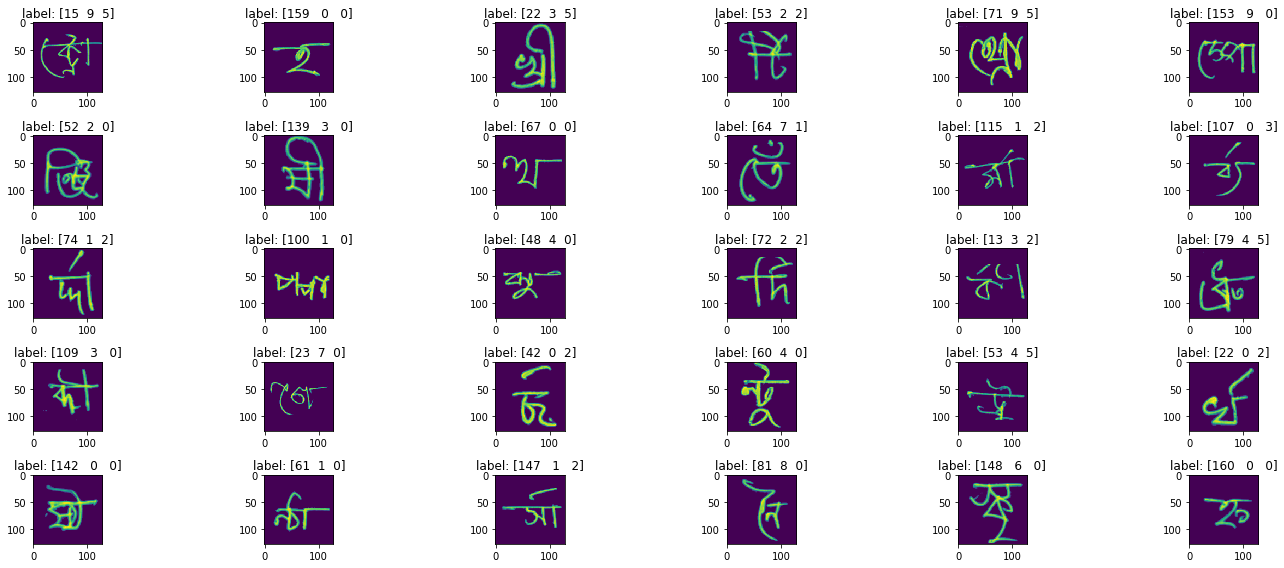

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

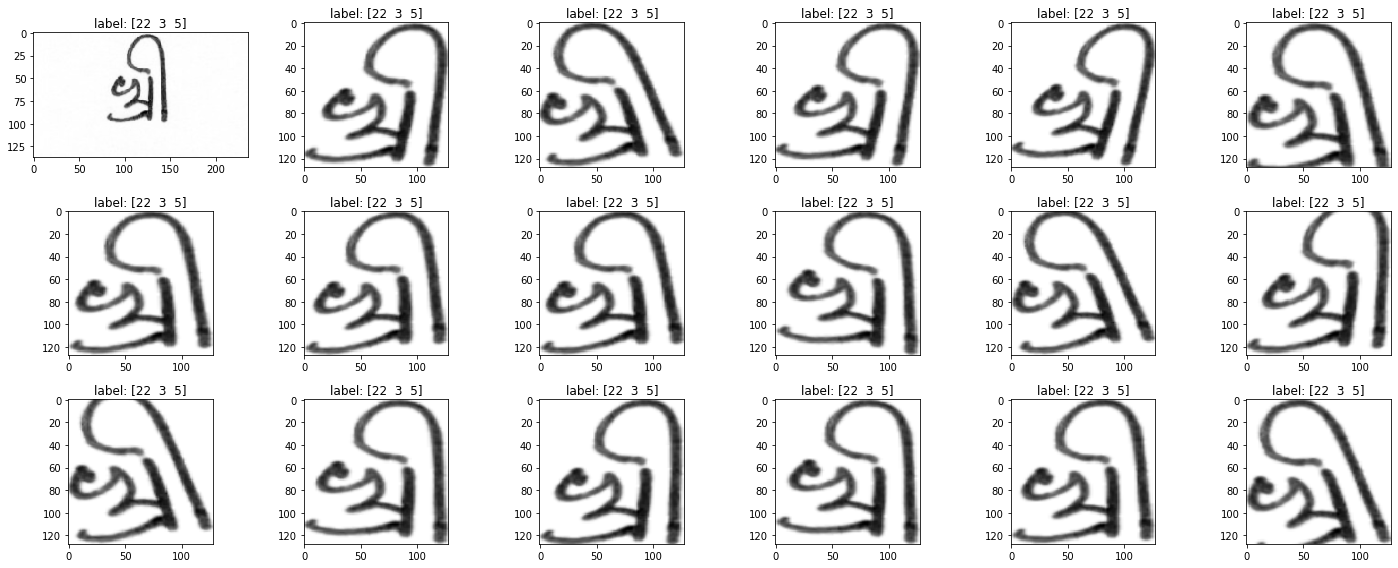

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

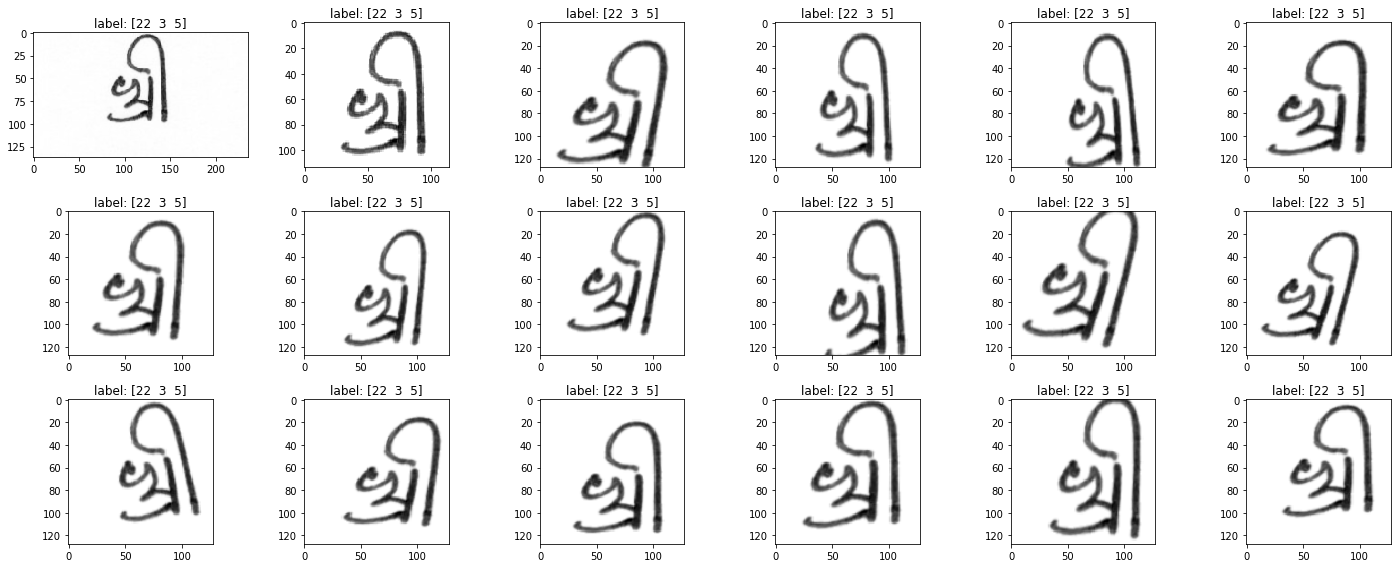

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

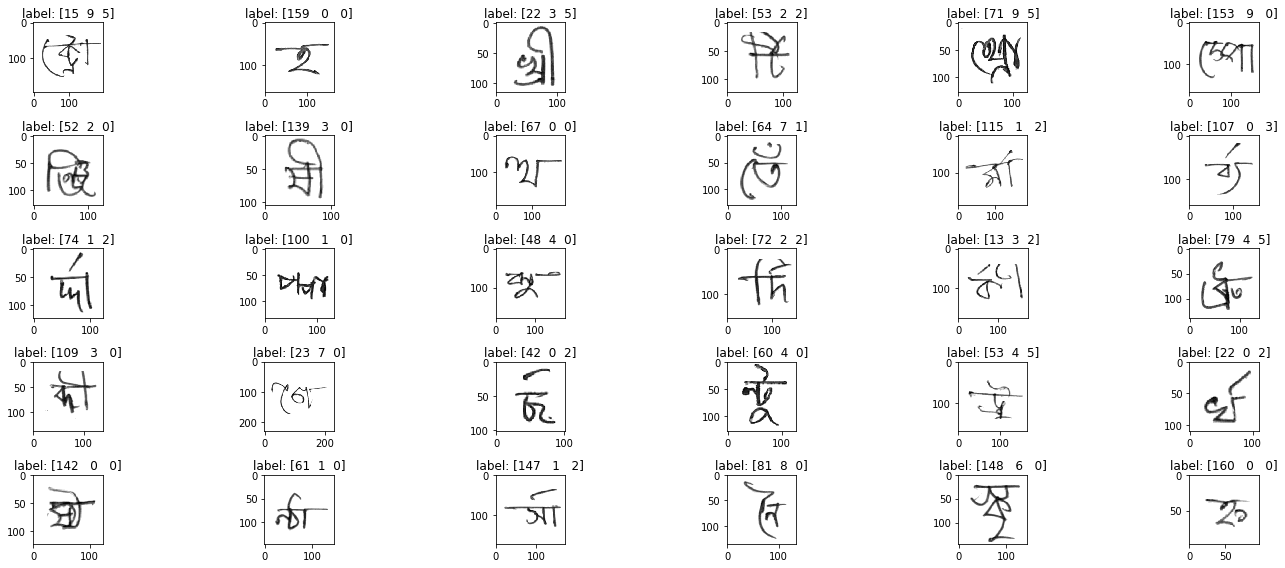

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

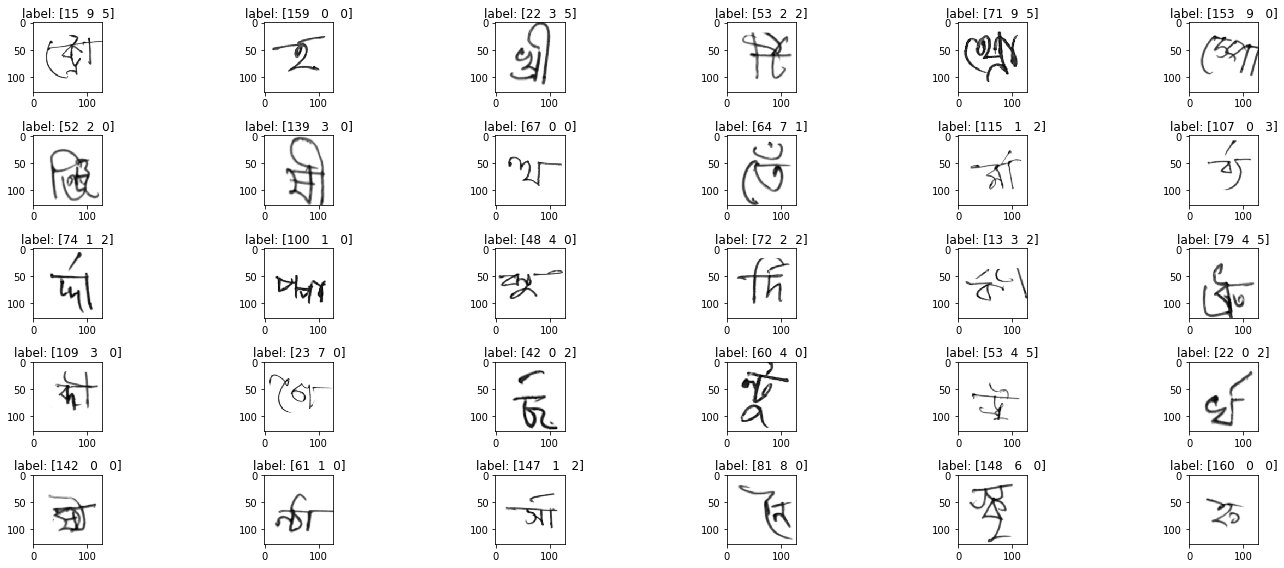

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(
    size=(image_size, image_size), cutout_ratio=0.5) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

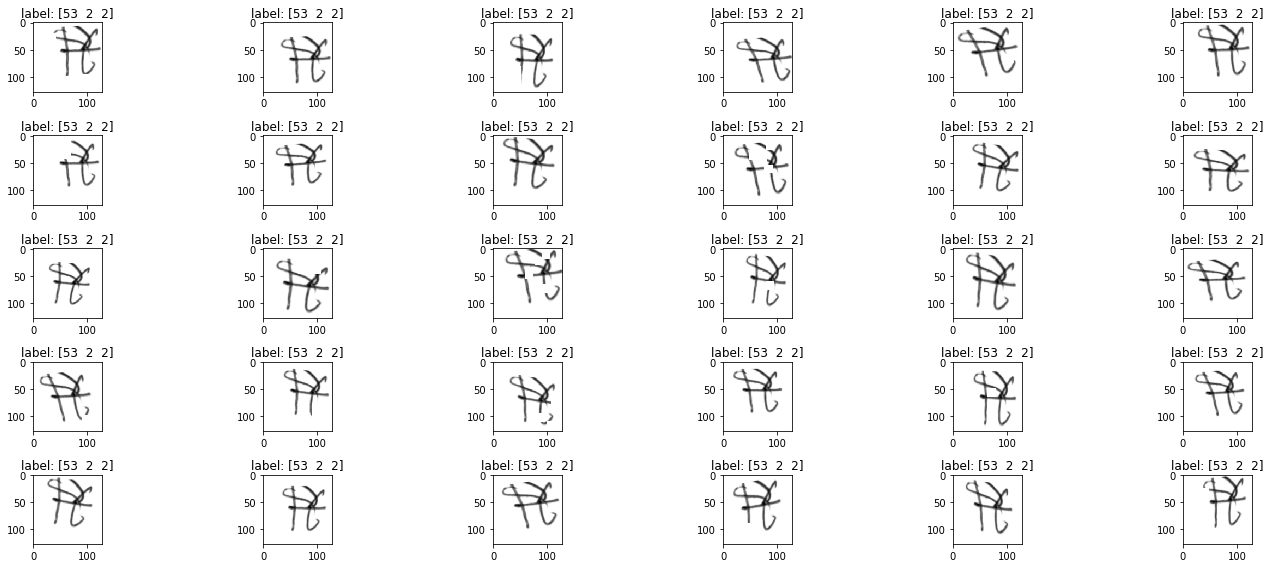

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

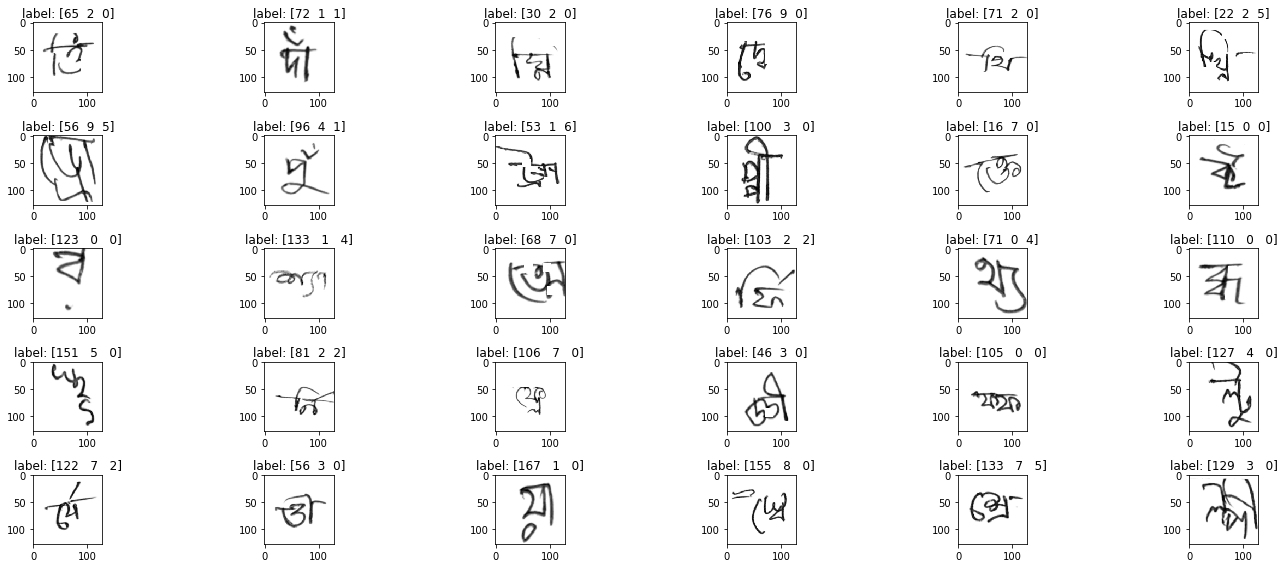

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

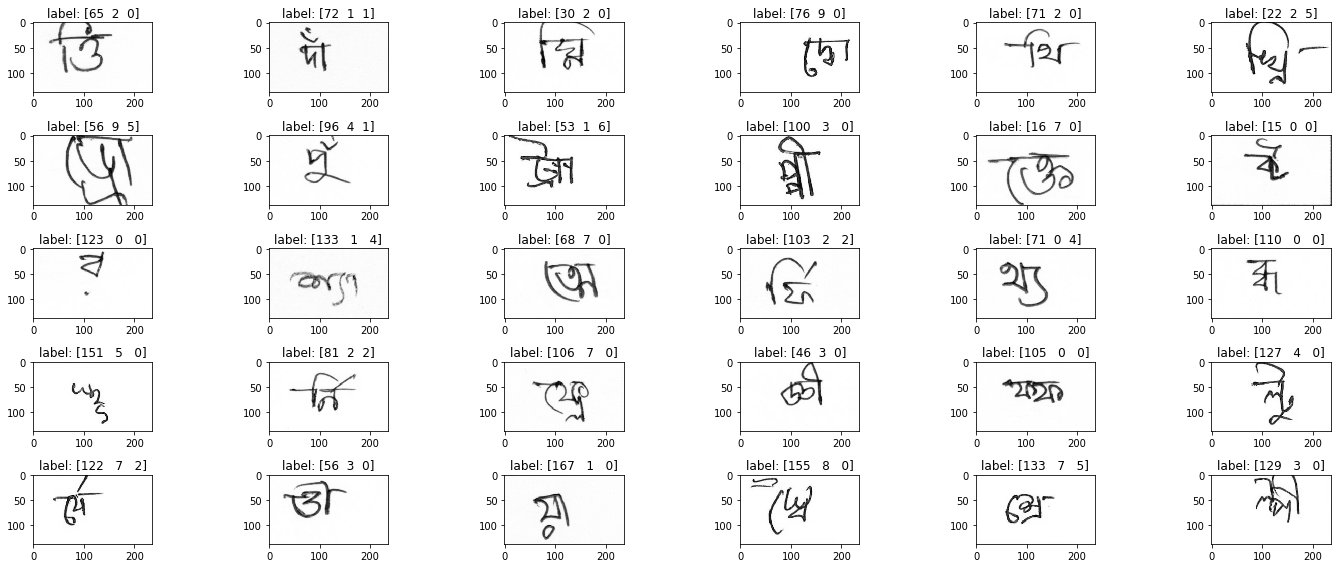

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 1000, dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

In [34]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [35]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [36]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [37]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         print(self.base_model)
        names = []
        for name, child in self.base_model.named_children():
            names.append(name)
            
        arch = self.base_model
        arch = list(arch.children())
        #saving the weights of the forst conv in w
        w = arch[0][0].weight
        #creating new Conv2d to accept 1 channel 
        arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #substituting weights of newly created Conv2d with w from but we have to take mean
        #to go from  3 channel to 1
        arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
        arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
#         print(arch)
        self.base_model = arch
#         print("#######################################")
#         print(self.base_model)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        
        hdim = 1024
        self.classifer = ClassifierNew(inp = inch, h1=hdim, out = out_dim, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.base_model.layer0(x)
        h = self.base_model.layer1(h)
        h = self.base_model.layer2(h)
        h = self.base_model.layer3(h)
        h = self.base_model.layer4(h)
        
        h = self.classifer(h)

        return h

In [38]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [39]:
# print_grad_status(predictortmp)

In [40]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [41]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [42]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [43]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [44]:
predictortmp = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
for name, child in predictortmp.named_children():
    print(name)
print_base_layers(predictortmp)

base_model
classifer
base model layer names::
layer0
layer1
layer2
layer3
layer4
avg_pool
last_linear


In [45]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [46]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.base_model.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-6)
    lr_10 = max(learning_rate/10, 5e-6)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
        dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
        dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [48]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [49]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [50]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [51]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [52]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [53]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [54]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [55]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [56]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [57]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [58]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [59]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=3e-4)
    optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  2.471862 train/loss_grapheme  1.933033 train/loss_vowel  0.295074 train/loss_consonant  0.243755 train/acc_grapheme  0.746091 train/acc_vowel  0.909020 train/acc_consonant  0.924517 train/recall  0.762633 val/loss  0.811775 val/loss_grapheme  0.625954 val/loss_vowel  0.091549 val/loss_consonant  0.094271 val/acc_grapheme  0.909231 val/acc_vowel  0.974183 val/acc_consonant  0.972192 val/recall  0.906020 lr  0.001000 elapsed_time  613.423464 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  1.072330 train/loss_grapheme  0.820460 train/loss_vowel  0.129807 train/loss_consonant  0.122063 train/acc_grapheme  0.882450 train/acc_vowel  0.962433 train/acc_consonant  0.963012 train/recall  0.879859 val/loss  0.642832 val/loss_grapheme  0.492767 val/loss_vowel  0.073441 val/loss_consonant  0.076624 val/acc_grapheme  0.927679 val/acc_vowel  0.980258 val/acc_consonant  0.977395 val/recall  0.924773 lr  0.001000 elapsed_time  1223.094408 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.879499 train/loss_grapheme  0.668517 train/loss_vowel  0.108929 train/loss_consonant  0.102053 train/acc_grapheme  0.902422 train/acc_vowel  0.969024 train/acc_consonant  0.969590 train/recall  0.898408 val/loss  0.571756 val/loss_grapheme  0.435792 val/loss_vowel  0.065937 val/loss_consonant  0.070028 val/acc_grapheme  0.938135 val/acc_vowel  0.981727 val/acc_consonant  0.979984 val/recall  0.935227 lr  0.001000 elapsed_time  1825.478408 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.765491 train/loss_grapheme  0.579729 train/loss_vowel  0.095607 train/loss_consonant  0.090156 train/acc_grapheme  0.915829 train/acc_vowel  0.973051 train/acc_consonant  0.973499 train/recall  0.912303 val/loss  0.512346 val/loss_grapheme  0.386223 val/loss_vowel  0.064567 val/loss_consonant  0.061557 val/acc_grapheme  0.944085 val/acc_vowel  0.982573 val/acc_consonant  0.982673 val/recall  0.941048 lr  0.001000 elapsed_time  2426.828176 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.693421 train/loss_grapheme  0.522164 train/loss_vowel  0.087410 train/loss_consonant  0.083847 train/acc_grapheme  0.923758 train/acc_vowel  0.975447 train/acc_consonant  0.975727 train/recall  0.919833 val/loss  0.495292 val/loss_grapheme  0.370277 val/loss_vowel  0.059818 val/loss_consonant  0.065197 val/acc_grapheme  0.946624 val/acc_vowel  0.984241 val/acc_consonant  0.981304 val/recall  0.941734 lr  0.001000 elapsed_time  3027.237759 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.630831 train/loss_grapheme  0.472312 train/loss_vowel  0.081523 train/loss_consonant  0.076996 train/acc_grapheme  0.930274 train/acc_vowel  0.977233 train/acc_consonant  0.977071 train/recall  0.926534 val/loss  0.486564 val/loss_grapheme  0.367254 val/loss_vowel  0.060493 val/loss_consonant  0.058817 val/acc_grapheme  0.946798 val/acc_vowel  0.983768 val/acc_consonant  0.983370 val/recall  0.943404 lr  0.001000 elapsed_time  3626.617785 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.573572 train/loss_grapheme  0.427724 train/loss_vowel  0.074597 train/loss_consonant  0.071252 train/acc_grapheme  0.935813 train/acc_vowel  0.979436 train/acc_consonant  0.978994 train/recall  0.931148 val/loss  0.447337 val/loss_grapheme  0.333926 val/loss_vowel  0.054902 val/loss_consonant  0.058510 val/acc_grapheme  0.952450 val/acc_vowel  0.986532 val/acc_consonant  0.983768 val/recall  0.947784 lr  0.001000 elapsed_time  4226.406775 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.546160 train/loss_grapheme  0.408038 train/loss_vowel  0.070005 train/loss_consonant  0.068117 train/acc_grapheme  0.939461 train/acc_vowel  0.980333 train/acc_consonant  0.980171 train/recall  0.935375 val/loss  0.459743 val/loss_grapheme  0.347912 val/loss_vowel  0.055527 val/loss_consonant  0.056304 val/acc_grapheme  0.951080 val/acc_vowel  0.985362 val/acc_consonant  0.984092 val/recall  0.947817 lr  0.001000 elapsed_time  4824.473067 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.509095 train/loss_grapheme  0.379852 train/loss_vowel  0.065087 train/loss_consonant  0.064156 train/acc_grapheme  0.942921 train/acc_vowel  0.981857 train/acc_consonant  0.981478 train/recall  0.938672 val/loss  0.441919 val/loss_grapheme  0.335428 val/loss_vowel  0.052778 val/loss_consonant  0.053713 val/acc_grapheme  0.954765 val/acc_vowel  0.986532 val/acc_consonant  0.985262 val/recall  0.950834 lr  0.001000 elapsed_time  5424.141418 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.485747 train/loss_grapheme  0.360380 train/loss_vowel  0.064380 train/loss_consonant  0.060987 train/acc_grapheme  0.946058 train/acc_vowel  0.981982 train/acc_consonant  0.982262 train/recall  0.942353 val/loss  0.444040 val/loss_grapheme  0.333341 val/loss_vowel  0.053839 val/loss_consonant  0.056860 val/acc_grapheme  0.954118 val/acc_vowel  0.986208 val/acc_consonant  0.984067 val/recall  0.949137 lr  0.001000 elapsed_time  6023.683518 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.454438 train/loss_grapheme  0.337457 train/loss_vowel  0.059133 train/loss_consonant  0.057847 train/acc_grapheme  0.949269 train/acc_vowel  0.983501 train/acc_consonant  0.983034 train/recall  0.945708 val/loss  0.425617 val/loss_grapheme  0.317849 val/loss_vowel  0.053663 val/loss_consonant  0.054104 val/acc_grapheme  0.956159 val/acc_vowel  0.986507 val/acc_consonant  0.985536 val/recall  0.952266 lr  0.001000 elapsed_time  6623.144707 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.438093 train/loss_grapheme  0.324272 train/loss_vowel  0.057840 train/loss_consonant  0.055981 train/acc_grapheme  0.950620 train/acc_vowel  0.983924 train/acc_consonant  0.983401 train/recall  0.946814 val/loss  0.428116 val/loss_grapheme  0.325216 val/loss_vowel  0.050097 val/loss_consonant  0.052803 val/acc_grapheme  0.954989 val/acc_vowel  0.987229 val/acc_consonant  0.985436 val/recall  0.952001 lr  0.001000 elapsed_time  7220.992233 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.415689 train/loss_grapheme  0.306313 train/loss_vowel  0.055215 train/loss_consonant  0.054161 train/acc_grapheme  0.953421 train/acc_vowel  0.984503 train/acc_consonant  0.983936 train/recall  0.949547 val/loss  0.425730 val/loss_grapheme  0.322620 val/loss_vowel  0.049246 val/loss_consonant  0.053864 val/acc_grapheme  0.955985 val/acc_vowel  0.988050 val/acc_consonant  0.985212 val/recall  0.953461 lr  0.001000 elapsed_time  7821.376932 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.401612 train/loss_grapheme  0.295515 train/loss_vowel  0.054205 train/loss_consonant  0.051892 train/acc_grapheme  0.955170 train/acc_vowel  0.984764 train/acc_consonant  0.984627 train/recall  0.951378 val/loss  0.440185 val/loss_grapheme  0.330928 val/loss_vowel  0.052662 val/loss_consonant  0.056596 val/acc_grapheme  0.955213 val/acc_vowel  0.986756 val/acc_consonant  0.984764 val/recall  0.951696 lr  0.001000 elapsed_time  8419.902603 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.384427 train/loss_grapheme  0.280831 train/loss_vowel  0.052358 train/loss_consonant  0.051238 train/acc_grapheme  0.956881 train/acc_vowel  0.985362 train/acc_consonant  0.984826 train/recall  0.952766 val/loss  0.433823 val/loss_grapheme  0.321048 val/loss_vowel  0.052052 val/loss_consonant  0.060723 val/acc_grapheme  0.958425 val/acc_vowel  0.987976 val/acc_consonant  0.983793 val/recall  0.953855 lr  0.001000 elapsed_time  9017.521034 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.371350 train/loss_grapheme  0.271272 train/loss_vowel  0.050088 train/loss_consonant  0.049991 train/acc_grapheme  0.958095 train/acc_vowel  0.985567 train/acc_consonant  0.985231 train/recall  0.954558 val/loss  0.423533 val/loss_grapheme  0.319383 val/loss_vowel  0.052224 val/loss_consonant  0.051926 val/acc_grapheme  0.957429 val/acc_vowel  0.987677 val/acc_consonant  0.986034 val/recall  0.953945 lr  0.001000 elapsed_time  9615.747076 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.363081 train/loss_grapheme  0.267661 train/loss_vowel  0.048692 train/loss_consonant  0.046728 train/acc_grapheme  0.958767 train/acc_vowel  0.986108 train/acc_consonant  0.986382 train/recall  0.954649 val/loss  0.428589 val/loss_grapheme  0.325662 val/loss_vowel  0.050678 val/loss_consonant  0.052249 val/acc_grapheme  0.956956 val/acc_vowel  0.987552 val/acc_consonant  0.986133 val/recall  0.953347 lr  0.001000 elapsed_time  10215.733361 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.351528 train/loss_grapheme  0.257825 train/loss_vowel  0.045873 train/loss_consonant  0.047830 train/acc_grapheme  0.959819 train/acc_vowel  0.987092 train/acc_consonant  0.985691 train/recall  0.955667 val/loss  0.426489 val/loss_grapheme  0.322722 val/loss_vowel  0.051049 val/loss_consonant  0.052718 val/acc_grapheme  0.956383 val/acc_vowel  0.987278 val/acc_consonant  0.985909 val/recall  0.952728 lr  0.001000 elapsed_time  10815.216187 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.335974 train/loss_grapheme  0.247992 train/loss_vowel  0.044434 train/loss_consonant  0.043548 train/acc_grapheme  0.961250 train/acc_vowel  0.987135 train/acc_consonant  0.987235 train/recall  0.957780 val/loss  0.436630 val/loss_grapheme  0.329087 val/loss_vowel  0.050810 val/loss_consonant  0.056732 val/acc_grapheme  0.958026 val/acc_vowel  0.987478 val/acc_consonant  0.985137 val/recall  0.954058 lr  0.001000 elapsed_time  11414.568249 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.329780 train/loss_grapheme  0.241098 train/loss_vowel  0.044189 train/loss_consonant  0.044493 train/acc_grapheme  0.962943 train/acc_vowel  0.986942 train/acc_consonant  0.986637 train/recall  0.959486 val/loss  0.437102 val/loss_grapheme  0.332818 val/loss_vowel  0.049490 val/loss_consonant  0.054794 val/acc_grapheme  0.957927 val/acc_vowel  0.988274 val/acc_consonant  0.985934 val/recall  0.955856 lr  0.001000 elapsed_time  12013.792286 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.317618 train/loss_grapheme  0.233233 train/loss_vowel  0.041523 train/loss_consonant  0.042861 train/acc_grapheme  0.964063 train/acc_vowel  0.988156 train/acc_consonant  0.987023 train/recall  0.961095 val/loss  0.422612 val/loss_grapheme  0.321231 val/loss_vowel  0.049531 val/loss_consonant  0.051850 val/acc_grapheme  0.957553 val/acc_vowel  0.988175 val/acc_consonant  0.986183 val/recall  0.954961 lr  0.001000 elapsed_time  12613.257398 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.307653 train/loss_grapheme  0.224940 train/loss_vowel  0.041748 train/loss_consonant  0.040965 train/acc_grapheme  0.965277 train/acc_vowel  0.987944 train/acc_consonant  0.987976 train/recall  0.961761 val/loss  0.423282 val/loss_grapheme  0.321825 val/loss_vowel  0.049829 val/loss_consonant  0.051628 val/acc_grapheme  0.957678 val/acc_vowel  0.988374 val/acc_consonant  0.986631 val/recall  0.954826 lr  0.001000 elapsed_time  13211.700531 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.299939 train/loss_grapheme  0.218338 train/loss_vowel  0.041186 train/loss_consonant  0.040415 train/acc_grapheme  0.966590 train/acc_vowel  0.987938 train/acc_consonant  0.987627 train/recall  0.962834 val/loss  0.429623 val/loss_grapheme  0.326625 val/loss_vowel  0.051272 val/loss_consonant  0.051726 val/acc_grapheme  0.959122 val/acc_vowel  0.987328 val/acc_consonant  0.986482 val/recall  0.954864 lr  0.001000 elapsed_time  13810.401967 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.291750 train/loss_grapheme  0.213842 train/loss_vowel  0.039488 train/loss_consonant  0.038420 train/acc_grapheme  0.966783 train/acc_vowel  0.988224 train/acc_consonant  0.988181 train/recall  0.963135 val/loss  0.427945 val/loss_grapheme  0.325128 val/loss_vowel  0.049534 val/loss_consonant  0.053282 val/acc_grapheme  0.959420 val/acc_vowel  0.988075 val/acc_consonant  0.986034 val/recall  0.954883 lr  0.001000 elapsed_time  14409.384878 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.285429 train/loss_grapheme  0.208237 train/loss_vowel  0.038942 train/loss_consonant  0.038250 train/acc_grapheme  0.967711 train/acc_vowel  0.988778 train/acc_consonant  0.988561 train/recall  0.964685 val/loss  0.438057 val/loss_grapheme  0.333852 val/loss_vowel  0.049931 val/loss_consonant  0.054274 val/acc_grapheme  0.957255 val/acc_vowel  0.988050 val/acc_consonant  0.985760 val/recall  0.953840 lr  0.001000 elapsed_time  15008.130811 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.279573 train/loss_grapheme  0.203467 train/loss_vowel  0.038274 train/loss_consonant  0.037832 train/acc_grapheme  0.968271 train/acc_vowel  0.988797 train/acc_consonant  0.988592 train/recall  0.964802 val/loss  0.433072 val/loss_grapheme  0.330319 val/loss_vowel  0.049580 val/loss_consonant  0.053173 val/acc_grapheme  0.958400 val/acc_vowel  0.988697 val/acc_consonant  0.986781 val/recall  0.955258 lr  0.001000 elapsed_time  15606.347084 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.270523 train/loss_grapheme  0.195201 train/loss_vowel  0.036862 train/loss_consonant  0.038460 train/acc_grapheme  0.969771 train/acc_vowel  0.989314 train/acc_consonant  0.988461 train/recall  0.966290 val/loss  0.444937 val/loss_grapheme  0.342055 val/loss_vowel  0.049453 val/loss_consonant  0.053429 val/acc_grapheme  0.958250 val/acc_vowel  0.988050 val/acc_consonant  0.986507 val/recall  0.955052 lr  0.001000 elapsed_time  16204.064783 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.214713 train/loss_grapheme  0.154291 train/loss_vowel  0.029828 train/loss_consonant  0.030594 train/acc_grapheme  0.976119 train/acc_vowel  0.991249 train/acc_consonant  0.990838 train/recall  0.973830 val/loss  0.424931 val/loss_grapheme  0.325433 val/loss_vowel  0.047630 val/loss_consonant  0.051868 val/acc_grapheme  0.962134 val/acc_vowel  0.989444 val/acc_consonant  0.987428 val/recall  0.959174 lr  0.000500 elapsed_time  16803.049288 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.193009 train/loss_grapheme  0.138187 train/loss_vowel  0.027018 train/loss_consonant  0.027805 train/acc_grapheme  0.978627 train/acc_vowel  0.992077 train/acc_consonant  0.991405 train/recall  0.975975 val/loss  0.424315 val/loss_grapheme  0.324494 val/loss_vowel  0.047074 val/loss_consonant  0.052747 val/acc_grapheme  0.961238 val/acc_vowel  0.989718 val/acc_consonant  0.987378 val/recall  0.958258 lr  0.000500 elapsed_time  17401.615072 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.190396 train/loss_grapheme  0.136772 train/loss_vowel  0.027365 train/loss_consonant  0.026259 train/acc_grapheme  0.978833 train/acc_vowel  0.991822 train/acc_consonant  0.992040 train/recall  0.976263 val/loss  0.435956 val/loss_grapheme  0.332749 val/loss_vowel  0.048444 val/loss_consonant  0.054763 val/acc_grapheme  0.963404 val/acc_vowel  0.989843 val/acc_consonant  0.987453 val/recall  0.960556 lr  0.000500 elapsed_time  17999.462531 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.182947 train/loss_grapheme  0.130783 train/loss_vowel  0.026421 train/loss_consonant  0.025743 train/acc_grapheme  0.979866 train/acc_vowel  0.992208 train/acc_consonant  0.992239 train/recall  0.977400 val/loss  0.433994 val/loss_grapheme  0.329770 val/loss_vowel  0.051058 val/loss_consonant  0.053166 val/acc_grapheme  0.962308 val/acc_vowel  0.989718 val/acc_consonant  0.987527 val/recall  0.959354 lr  0.000500 elapsed_time  18597.129371 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.176165 train/loss_grapheme  0.127031 train/loss_vowel  0.023628 train/loss_consonant  0.025506 train/acc_grapheme  0.980382 train/acc_vowel  0.992836 train/acc_consonant  0.992158 train/recall  0.978317 val/loss  0.451183 val/loss_grapheme  0.343169 val/loss_vowel  0.051615 val/loss_consonant  0.056399 val/acc_grapheme  0.963304 val/acc_vowel  0.989494 val/acc_consonant  0.987303 val/recall  0.959539 lr  0.000500 elapsed_time  19197.146097 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.177002 train/loss_grapheme  0.125788 train/loss_vowel  0.025378 train/loss_consonant  0.025837 train/acc_grapheme  0.980519 train/acc_vowel  0.992289 train/acc_consonant  0.992146 train/recall  0.977919 val/loss  0.448139 val/loss_grapheme  0.342197 val/loss_vowel  0.050814 val/loss_consonant  0.055128 val/acc_grapheme  0.963404 val/acc_vowel  0.989868 val/acc_consonant  0.987876 val/recall  0.960768 lr  0.000500 elapsed_time  19795.489081 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.152333 train/loss_grapheme  0.110580 train/loss_vowel  0.021017 train/loss_consonant  0.020736 train/acc_grapheme  0.983046 train/acc_vowel  0.993701 train/acc_consonant  0.993540 train/recall  0.981223 val/loss  0.438481 val/loss_grapheme  0.334650 val/loss_vowel  0.048757 val/loss_consonant  0.055074 val/acc_grapheme  0.964424 val/acc_vowel  0.990042 val/acc_consonant  0.988075 val/recall  0.961683 lr  0.000250 elapsed_time  20395.145531 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.145897 train/loss_grapheme  0.105263 train/loss_vowel  0.019788 train/loss_consonant  0.020846 train/acc_grapheme  0.984111 train/acc_vowel  0.993901 train/acc_consonant  0.993739 train/recall  0.982507 val/loss  0.445336 val/loss_grapheme  0.337847 val/loss_vowel  0.050707 val/loss_consonant  0.056782 val/acc_grapheme  0.965072 val/acc_vowel  0.989668 val/acc_consonant  0.988175 val/recall  0.961905 lr  0.000250 elapsed_time  20995.152875 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.141469 train/loss_grapheme  0.101963 train/loss_vowel  0.019209 train/loss_consonant  0.020297 train/acc_grapheme  0.984584 train/acc_vowel  0.993894 train/acc_consonant  0.993894 train/recall  0.982817 val/loss  0.442283 val/loss_grapheme  0.337264 val/loss_vowel  0.050160 val/loss_consonant  0.054859 val/acc_grapheme  0.964897 val/acc_vowel  0.990266 val/acc_consonant  0.987527 val/recall  0.961793 lr  0.000250 elapsed_time  21594.008322 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.137126 train/loss_grapheme  0.099366 train/loss_vowel  0.018680 train/loss_consonant  0.019080 train/acc_grapheme  0.984776 train/acc_vowel  0.994311 train/acc_consonant  0.994056 train/recall  0.983756 val/loss  0.444049 val/loss_grapheme  0.334313 val/loss_vowel  0.052532 val/loss_consonant  0.057205 val/acc_grapheme  0.964748 val/acc_vowel  0.989942 val/acc_consonant  0.987801 val/recall  0.961665 lr  0.000250 elapsed_time  22192.508442 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.136927 train/loss_grapheme  0.100213 train/loss_vowel  0.018281 train/loss_consonant  0.018433 train/acc_grapheme  0.984895 train/acc_vowel  0.994448 train/acc_consonant  0.994280 train/recall  0.983578 val/loss  0.447057 val/loss_grapheme  0.339269 val/loss_vowel  0.051585 val/loss_consonant  0.056203 val/acc_grapheme  0.964574 val/acc_vowel  0.989942 val/acc_consonant  0.988274 val/recall  0.961553 lr  0.000250 elapsed_time  22791.069673 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.131740 train/loss_grapheme  0.094540 train/loss_vowel  0.018191 train/loss_consonant  0.019008 train/acc_grapheme  0.985673 train/acc_vowel  0.994442 train/acc_consonant  0.994392 train/recall  0.984669 val/loss  0.444385 val/loss_grapheme  0.337431 val/loss_vowel  0.050407 val/loss_consonant  0.056547 val/acc_grapheme  0.964972 val/acc_vowel  0.989917 val/acc_consonant  0.988000 val/recall  0.961550 lr  0.000250 elapsed_time  23389.787158 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.126187 train/loss_grapheme  0.091199 train/loss_vowel  0.016770 train/loss_consonant  0.018218 train/acc_grapheme  0.986276 train/acc_vowel  0.994697 train/acc_consonant  0.994679 train/recall  0.984978 val/loss  0.443014 val/loss_grapheme  0.336810 val/loss_vowel  0.049839 val/loss_consonant  0.056365 val/acc_grapheme  0.966391 val/acc_vowel  0.990092 val/acc_consonant  0.988349 val/recall  0.962834 lr  0.000125 elapsed_time  23989.014662 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.119204 train/loss_grapheme  0.086086 train/loss_vowel  0.016288 train/loss_consonant  0.016830 train/acc_grapheme  0.987067 train/acc_vowel  0.995114 train/acc_consonant  0.994797 train/recall  0.985459 val/loss  0.453704 val/loss_grapheme  0.344881 val/loss_vowel  0.051549 val/loss_consonant  0.057274 val/acc_grapheme  0.965097 val/acc_vowel  0.990241 val/acc_consonant  0.988125 val/recall  0.961919 lr  0.000125 elapsed_time  24588.294268 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.113904 train/loss_grapheme  0.083136 train/loss_vowel  0.014365 train/loss_consonant  0.016403 train/acc_grapheme  0.987173 train/acc_vowel  0.995562 train/acc_consonant  0.994809 train/recall  0.986119 val/loss  0.449749 val/loss_grapheme  0.340670 val/loss_vowel  0.051660 val/loss_consonant  0.057419 val/acc_grapheme  0.965346 val/acc_vowel  0.989868 val/acc_consonant  0.988324 val/recall  0.962415 lr  0.000125 elapsed_time  25186.263982 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.119927 train/loss_grapheme  0.088396 train/loss_vowel  0.015678 train/loss_consonant  0.015853 train/acc_grapheme  0.986612 train/acc_vowel  0.995276 train/acc_consonant  0.995170 train/recall  0.986055 val/loss  0.456387 val/loss_grapheme  0.346303 val/loss_vowel  0.052253 val/loss_consonant  0.057832 val/acc_grapheme  0.966018 val/acc_vowel  0.990415 val/acc_consonant  0.988200 val/recall  0.962570 lr  0.000125 elapsed_time  25785.467466 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.114750 train/loss_grapheme  0.083031 train/loss_vowel  0.015363 train/loss_consonant  0.016356 train/acc_grapheme  0.987415 train/acc_vowel  0.995102 train/acc_consonant  0.994990 train/recall  0.986139 val/loss  0.454772 val/loss_grapheme  0.345116 val/loss_vowel  0.052767 val/loss_consonant  0.056889 val/acc_grapheme  0.965843 val/acc_vowel  0.990017 val/acc_consonant  0.988175 val/recall  0.962332 lr  0.000125 elapsed_time  26388.702584 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.113865 train/loss_grapheme  0.082916 train/loss_vowel  0.015248 train/loss_consonant  0.015701 train/acc_grapheme  0.987397 train/acc_vowel  0.995270 train/acc_consonant  0.995264 train/recall  0.986734 val/loss  0.457340 val/loss_grapheme  0.346293 val/loss_vowel  0.052796 val/loss_consonant  0.058251 val/acc_grapheme  0.965694 val/acc_vowel  0.990490 val/acc_consonant  0.988324 val/recall  0.963203 lr  0.000125 elapsed_time  27006.328806 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.107987 train/loss_grapheme  0.077606 train/loss_vowel  0.014464 train/loss_consonant  0.015917 train/acc_grapheme  0.988081 train/acc_vowel  0.995631 train/acc_consonant  0.995270 train/recall  0.987248 val/loss  0.458145 val/loss_grapheme  0.347747 val/loss_vowel  0.052181 val/loss_consonant  0.058216 val/acc_grapheme  0.965868 val/acc_vowel  0.990590 val/acc_consonant  0.988747 val/recall  0.962907 lr  0.000063 elapsed_time  27625.743774 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.106387 train/loss_grapheme  0.077741 train/loss_vowel  0.013905 train/loss_consonant  0.014741 train/acc_grapheme  0.988361 train/acc_vowel  0.995693 train/acc_consonant  0.995687 train/recall  0.987171 val/loss  0.459093 val/loss_grapheme  0.348194 val/loss_vowel  0.052196 val/loss_consonant  0.058703 val/acc_grapheme  0.966391 val/acc_vowel  0.990415 val/acc_consonant  0.988349 val/recall  0.963249 lr  0.000063 elapsed_time  28245.963732 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.106993 train/loss_grapheme  0.079594 train/loss_vowel  0.013152 train/loss_consonant  0.014247 train/acc_grapheme  0.987845 train/acc_vowel  0.995799 train/acc_consonant  0.995556 train/recall  0.986640 val/loss  0.457196 val/loss_grapheme  0.347025 val/loss_vowel  0.052117 val/loss_consonant  0.058054 val/acc_grapheme  0.966092 val/acc_vowel  0.990490 val/acc_consonant  0.988548 val/recall  0.963179 lr  0.000063 elapsed_time  28867.474742 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.105537 train/loss_grapheme  0.076812 train/loss_vowel  0.013769 train/loss_consonant  0.014956 train/acc_grapheme  0.988088 train/acc_vowel  0.995606 train/acc_consonant  0.995488 train/recall  0.987026 val/loss  0.457785 val/loss_grapheme  0.347502 val/loss_vowel  0.052247 val/loss_consonant  0.058036 val/acc_grapheme  0.966018 val/acc_vowel  0.990490 val/acc_consonant  0.988100 val/recall  0.962694 lr  0.000063 elapsed_time  29487.352188 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.107169 train/loss_grapheme  0.077464 train/loss_vowel  0.014880 train/loss_consonant  0.014826 train/acc_grapheme  0.988318 train/acc_vowel  0.995413 train/acc_consonant  0.995469 train/recall  0.987221 val/loss  0.457202 val/loss_grapheme  0.347232 val/loss_vowel  0.052770 val/loss_consonant  0.057199 val/acc_grapheme  0.966192 val/acc_vowel  0.990316 val/acc_consonant  0.988623 val/recall  0.963308 lr  0.000063 elapsed_time  30106.089320 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.105415 train/loss_grapheme  0.077296 train/loss_vowel  0.013460 train/loss_consonant  0.014658 train/acc_grapheme  0.988137 train/acc_vowel  0.995867 train/acc_consonant  0.995637 train/recall  0.987580 val/loss  0.456493 val/loss_grapheme  0.346816 val/loss_vowel  0.052046 val/loss_consonant  0.057632 val/acc_grapheme  0.966391 val/acc_vowel  0.990689 val/acc_consonant  0.988922 val/recall  0.963344 lr  0.000063 elapsed_time  30724.466078 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.100593 train/loss_grapheme  0.074825 train/loss_vowel  0.012088 train/loss_consonant  0.013679 train/acc_grapheme  0.988529 train/acc_vowel  0.996222 train/acc_consonant  0.995650 train/recall  0.987836 val/loss  0.452253 val/loss_grapheme  0.343357 val/loss_vowel  0.052158 val/loss_consonant  0.056739 val/acc_grapheme  0.966715 val/acc_vowel  0.990789 val/acc_consonant  0.988473 val/recall  0.963559 lr  0.000031 elapsed_time  31341.092922 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.107371 train/loss_grapheme  0.079087 train/loss_vowel  0.013932 train/loss_consonant  0.014352 train/acc_grapheme  0.988218 train/acc_vowel  0.995724 train/acc_consonant  0.995650 train/recall  0.987222 val/loss  0.456535 val/loss_grapheme  0.346861 val/loss_vowel  0.052140 val/loss_consonant  0.057534 val/acc_grapheme  0.966814 val/acc_vowel  0.990689 val/acc_consonant  0.988747 val/recall  0.963642 lr  0.000031 elapsed_time  31961.813755 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.102959 train/loss_grapheme  0.075017 train/loss_vowel  0.012939 train/loss_consonant  0.015002 train/acc_grapheme  0.988567 train/acc_vowel  0.995936 train/acc_consonant  0.995544 train/recall  0.987650 val/loss  0.456560 val/loss_grapheme  0.346429 val/loss_vowel  0.052405 val/loss_consonant  0.057727 val/acc_grapheme  0.966690 val/acc_vowel  0.990490 val/acc_consonant  0.988822 val/recall  0.963494 lr  0.000031 elapsed_time  32580.210365 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.105153 train/loss_grapheme  0.077655 train/loss_vowel  0.013095 train/loss_consonant  0.014404 train/acc_grapheme  0.988561 train/acc_vowel  0.996073 train/acc_consonant  0.995525 train/recall  0.987866 val/loss  0.457973 val/loss_grapheme  0.347460 val/loss_vowel  0.052711 val/loss_consonant  0.057802 val/acc_grapheme  0.967014 val/acc_vowel  0.990440 val/acc_consonant  0.988498 val/recall  0.963383 lr  0.000031 elapsed_time  33198.372759 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.102035 train/loss_grapheme  0.075166 train/loss_vowel  0.012224 train/loss_consonant  0.014645 train/acc_grapheme  0.988480 train/acc_vowel  0.996266 train/acc_consonant  0.995867 train/recall  0.988134 val/loss  0.459465 val/loss_grapheme  0.347843 val/loss_vowel  0.053119 val/loss_consonant  0.058502 val/acc_grapheme  0.967238 val/acc_vowel  0.990316 val/acc_consonant  0.988822 val/recall  0.963798 lr  0.000031 elapsed_time  33816.468107 mode 001 


100%|██████████| 419/419 [01:01<00:00,  6.76it/s]


epoch     56 train/loss  0.099896 train/loss_grapheme  0.072132 train/loss_vowel  0.013655 train/loss_consonant  0.014109 train/acc_grapheme  0.989065 train/acc_vowel  0.995743 train/acc_consonant  0.995550 train/recall  0.987857 val/loss  0.457147 val/loss_grapheme  0.346236 val/loss_vowel  0.052287 val/loss_consonant  0.058624 val/acc_grapheme  0.966715 val/acc_vowel  0.990789 val/acc_consonant  0.988623 val/recall  0.963584 lr  0.000031 elapsed_time  34434.936840 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.103916 train/loss_grapheme  0.076481 train/loss_vowel  0.013004 train/loss_consonant  0.014430 train/acc_grapheme  0.988673 train/acc_vowel  0.996060 train/acc_consonant  0.995618 train/recall  0.987776 val/loss  0.457970 val/loss_grapheme  0.347605 val/loss_vowel  0.052252 val/loss_consonant  0.058113 val/acc_grapheme  0.966715 val/acc_vowel  0.990739 val/acc_consonant  0.988673 val/recall  0.963399 lr  0.000016 elapsed_time  35053.617060 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.100708 train/loss_grapheme  0.072487 train/loss_vowel  0.013028 train/loss_consonant  0.015193 train/acc_grapheme  0.988978 train/acc_vowel  0.996079 train/acc_consonant  0.995438 train/recall  0.988156 val/loss  0.459880 val/loss_grapheme  0.349262 val/loss_vowel  0.052765 val/loss_consonant  0.057852 val/acc_grapheme  0.967014 val/acc_vowel  0.990565 val/acc_consonant  0.988822 val/recall  0.963803 lr  0.000016 elapsed_time  35672.463805 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.101251 train/loss_grapheme  0.074059 train/loss_vowel  0.013050 train/loss_consonant  0.014143 train/acc_grapheme  0.988834 train/acc_vowel  0.996029 train/acc_consonant  0.995774 train/recall  0.987945 val/loss  0.456583 val/loss_grapheme  0.346778 val/loss_vowel  0.052221 val/loss_consonant  0.057584 val/acc_grapheme  0.966814 val/acc_vowel  0.990639 val/acc_consonant  0.988872 val/recall  0.963803 lr  0.000016 elapsed_time  36295.047979 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.101963 train/loss_grapheme  0.075603 train/loss_vowel  0.012555 train/loss_consonant  0.013806 train/acc_grapheme  0.988399 train/acc_vowel  0.996011 train/acc_consonant  0.995930 train/recall  0.987964 val/loss  0.460865 val/loss_grapheme  0.349784 val/loss_vowel  0.052996 val/loss_consonant  0.058085 val/acc_grapheme  0.966939 val/acc_vowel  0.990465 val/acc_consonant  0.989021 val/recall  0.963736 lr  0.000016 elapsed_time  36913.076664 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.099459 train/loss_grapheme  0.073059 train/loss_vowel  0.012972 train/loss_consonant  0.013428 train/acc_grapheme  0.988878 train/acc_vowel  0.995880 train/acc_consonant  0.995948 train/recall  0.988128 val/loss  0.456565 val/loss_grapheme  0.346287 val/loss_vowel  0.052745 val/loss_consonant  0.057534 val/acc_grapheme  0.966989 val/acc_vowel  0.990440 val/acc_consonant  0.988946 val/recall  0.963661 lr  0.000016 elapsed_time  37530.539747 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.098671 train/loss_grapheme  0.073442 train/loss_vowel  0.011437 train/loss_consonant  0.013793 train/acc_grapheme  0.988978 train/acc_vowel  0.996291 train/acc_consonant  0.995979 train/recall  0.988259 val/loss  0.453298 val/loss_grapheme  0.343923 val/loss_vowel  0.052421 val/loss_consonant  0.056954 val/acc_grapheme  0.967437 val/acc_vowel  0.990614 val/acc_consonant  0.988872 val/recall  0.964089 lr  0.000016 elapsed_time  38149.665533 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.101330 train/loss_grapheme  0.075581 train/loss_vowel  0.011899 train/loss_consonant  0.013851 train/acc_grapheme  0.988567 train/acc_vowel  0.996297 train/acc_consonant  0.995836 train/recall  0.987987 val/loss  0.454225 val/loss_grapheme  0.344800 val/loss_vowel  0.052294 val/loss_consonant  0.057131 val/acc_grapheme  0.966814 val/acc_vowel  0.990465 val/acc_consonant  0.988847 val/recall  0.963557 lr  0.000008 elapsed_time  38772.585201 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.100742 train/loss_grapheme  0.074777 train/loss_vowel  0.011748 train/loss_consonant  0.014218 train/acc_grapheme  0.988641 train/acc_vowel  0.996428 train/acc_consonant  0.995811 train/recall  0.988164 val/loss  0.454926 val/loss_grapheme  0.344684 val/loss_vowel  0.052724 val/loss_consonant  0.057518 val/acc_grapheme  0.967337 val/acc_vowel  0.990614 val/acc_consonant  0.988822 val/recall  0.964013 lr  0.000008 elapsed_time  39394.697840 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.099857 train/loss_grapheme  0.073808 train/loss_vowel  0.012901 train/loss_consonant  0.013148 train/acc_grapheme  0.988922 train/acc_vowel  0.995930 train/acc_consonant  0.996203 train/recall  0.988368 val/loss  0.457960 val/loss_grapheme  0.347124 val/loss_vowel  0.052854 val/loss_consonant  0.057982 val/acc_grapheme  0.966914 val/acc_vowel  0.990664 val/acc_consonant  0.988623 val/recall  0.963539 lr  0.000008 elapsed_time  40014.790257 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.099025 train/loss_grapheme  0.072677 train/loss_vowel  0.012041 train/loss_consonant  0.014307 train/acc_grapheme  0.989239 train/acc_vowel  0.996284 train/acc_consonant  0.995730 train/recall  0.988561 val/loss  0.456399 val/loss_grapheme  0.346305 val/loss_vowel  0.052630 val/loss_consonant  0.057465 val/acc_grapheme  0.966814 val/acc_vowel  0.990515 val/acc_consonant  0.988648 val/recall  0.963534 lr  0.000008 elapsed_time  40633.682091 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.099145 train/loss_grapheme  0.073279 train/loss_vowel  0.013158 train/loss_consonant  0.012708 train/acc_grapheme  0.988915 train/acc_vowel  0.995861 train/acc_consonant  0.996104 train/recall  0.987879 val/loss  0.453245 val/loss_grapheme  0.344500 val/loss_vowel  0.051767 val/loss_consonant  0.056979 val/acc_grapheme  0.967163 val/acc_vowel  0.990664 val/acc_consonant  0.988822 val/recall  0.964109 lr  0.000008 elapsed_time  41252.907505 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.098164 train/loss_grapheme  0.072149 train/loss_vowel  0.012458 train/loss_consonant  0.013557 train/acc_grapheme  0.989195 train/acc_vowel  0.996023 train/acc_consonant  0.995755 train/recall  0.988514 val/loss  0.455625 val/loss_grapheme  0.345709 val/loss_vowel  0.052492 val/loss_consonant  0.057423 val/acc_grapheme  0.967163 val/acc_vowel  0.990515 val/acc_consonant  0.988697 val/recall  0.963787 lr  0.000008 elapsed_time  41877.993668 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.70it/s]


epoch     69 train/loss  0.100855 train/loss_grapheme  0.073722 train/loss_vowel  0.013292 train/loss_consonant  0.013842 train/acc_grapheme  0.988990 train/acc_vowel  0.995930 train/acc_consonant  0.995861 train/recall  0.987958 val/loss  0.459830 val/loss_grapheme  0.348952 val/loss_vowel  0.052930 val/loss_consonant  0.057948 val/acc_grapheme  0.966690 val/acc_vowel  0.990440 val/acc_consonant  0.988747 val/recall  0.963551 lr  0.000004 elapsed_time  42496.822990 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.103105 train/loss_grapheme  0.076056 train/loss_vowel  0.013590 train/loss_consonant  0.013459 train/acc_grapheme  0.988399 train/acc_vowel  0.995936 train/acc_consonant  0.995936 train/recall  0.987792 val/loss  0.458343 val/loss_grapheme  0.347951 val/loss_vowel  0.052521 val/loss_consonant  0.057871 val/acc_grapheme  0.967138 val/acc_vowel  0.990565 val/acc_consonant  0.988847 val/recall  0.964038 lr  0.000004 elapsed_time  43121.443136 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.098685 train/loss_grapheme  0.073595 train/loss_vowel  0.012443 train/loss_consonant  0.012648 train/acc_grapheme  0.988897 train/acc_vowel  0.996166 train/acc_consonant  0.996203 train/recall  0.988195 val/loss  0.460613 val/loss_grapheme  0.349257 val/loss_vowel  0.052944 val/loss_consonant  0.058411 val/acc_grapheme  0.967038 val/acc_vowel  0.990515 val/acc_consonant  0.988648 val/recall  0.963542 lr  0.000004 elapsed_time  43740.619436 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.100748 train/loss_grapheme  0.074351 train/loss_vowel  0.012755 train/loss_consonant  0.013641 train/acc_grapheme  0.988847 train/acc_vowel  0.996098 train/acc_consonant  0.995687 train/recall  0.987930 val/loss  0.454763 val/loss_grapheme  0.344977 val/loss_vowel  0.052233 val/loss_consonant  0.057553 val/acc_grapheme  0.967213 val/acc_vowel  0.990490 val/acc_consonant  0.988623 val/recall  0.963649 lr  0.000004 elapsed_time  44358.926317 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.099430 train/loss_grapheme  0.073365 train/loss_vowel  0.012791 train/loss_consonant  0.013274 train/acc_grapheme  0.988722 train/acc_vowel  0.996011 train/acc_consonant  0.995880 train/recall  0.988029 val/loss  0.459740 val/loss_grapheme  0.349493 val/loss_vowel  0.052785 val/loss_consonant  0.057462 val/acc_grapheme  0.967113 val/acc_vowel  0.990614 val/acc_consonant  0.988872 val/recall  0.964020 lr  0.000004 elapsed_time  44979.967291 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.098530 train/loss_grapheme  0.072218 train/loss_vowel  0.012537 train/loss_consonant  0.013775 train/acc_grapheme  0.989108 train/acc_vowel  0.996235 train/acc_consonant  0.995786 train/recall  0.988372 val/loss  0.457156 val/loss_grapheme  0.347143 val/loss_vowel  0.052401 val/loss_consonant  0.057612 val/acc_grapheme  0.966989 val/acc_vowel  0.990316 val/acc_consonant  0.988797 val/recall  0.963718 lr  0.000004 elapsed_time  45598.082157 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.097035 train/loss_grapheme  0.071579 train/loss_vowel  0.011915 train/loss_consonant  0.013541 train/acc_grapheme  0.989058 train/acc_vowel  0.996185 train/acc_consonant  0.995898 train/recall  0.988384 val/loss  0.457376 val/loss_grapheme  0.347653 val/loss_vowel  0.052126 val/loss_consonant  0.057597 val/acc_grapheme  0.967188 val/acc_vowel  0.990490 val/acc_consonant  0.988996 val/recall  0.964134 lr  0.000002 elapsed_time  46215.944212 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.101296 train/loss_grapheme  0.074240 train/loss_vowel  0.013372 train/loss_consonant  0.013684 train/acc_grapheme  0.988822 train/acc_vowel  0.995936 train/acc_consonant  0.995793 train/recall  0.987604 val/loss  0.457096 val/loss_grapheme  0.346682 val/loss_vowel  0.052653 val/loss_consonant  0.057762 val/acc_grapheme  0.967462 val/acc_vowel  0.990540 val/acc_consonant  0.988922 val/recall  0.964189 lr  0.000002 elapsed_time  46836.862648 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.099910 train/loss_grapheme  0.072589 train/loss_vowel  0.012855 train/loss_consonant  0.014465 train/acc_grapheme  0.988884 train/acc_vowel  0.995967 train/acc_consonant  0.995674 train/recall  0.987764 val/loss  0.457518 val/loss_grapheme  0.347288 val/loss_vowel  0.052361 val/loss_consonant  0.057869 val/acc_grapheme  0.967113 val/acc_vowel  0.990490 val/acc_consonant  0.988996 val/recall  0.963977 lr  0.000002 elapsed_time  47457.903717 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.098886 train/loss_grapheme  0.073006 train/loss_vowel  0.012300 train/loss_consonant  0.013580 train/acc_grapheme  0.988946 train/acc_vowel  0.996160 train/acc_consonant  0.995880 train/recall  0.988111 val/loss  0.457515 val/loss_grapheme  0.347022 val/loss_vowel  0.052553 val/loss_consonant  0.057941 val/acc_grapheme  0.967437 val/acc_vowel  0.990540 val/acc_consonant  0.988623 val/recall  0.963980 lr  0.000002 elapsed_time  48076.430201 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.097467 train/loss_grapheme  0.071630 train/loss_vowel  0.012246 train/loss_consonant  0.013591 train/acc_grapheme  0.989121 train/acc_vowel  0.996210 train/acc_consonant  0.995687 train/recall  0.988403 val/loss  0.457883 val/loss_grapheme  0.347760 val/loss_vowel  0.052066 val/loss_consonant  0.058057 val/acc_grapheme  0.967462 val/acc_vowel  0.990490 val/acc_consonant  0.988822 val/recall  0.964049 lr  0.000002 elapsed_time  48695.752739 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.096232 train/loss_grapheme  0.070521 train/loss_vowel  0.012425 train/loss_consonant  0.013287 train/acc_grapheme  0.989544 train/acc_vowel  0.996179 train/acc_consonant  0.996135 train/recall  0.989121 val/loss  0.457911 val/loss_grapheme  0.347313 val/loss_vowel  0.052505 val/loss_consonant  0.058092 val/acc_grapheme  0.966964 val/acc_vowel  0.990540 val/acc_consonant  0.988722 val/recall  0.963675 lr  0.000002 elapsed_time  49316.769058 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.099310 train/loss_grapheme  0.073494 train/loss_vowel  0.012509 train/loss_consonant  0.013307 train/acc_grapheme  0.988928 train/acc_vowel  0.996154 train/acc_consonant  0.995811 train/recall  0.988083 val/loss  0.461178 val/loss_grapheme  0.350061 val/loss_vowel  0.052858 val/loss_consonant  0.058259 val/acc_grapheme  0.967063 val/acc_vowel  0.990639 val/acc_consonant  0.988996 val/recall  0.963921 lr  0.000001 elapsed_time  49935.671898 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.097660 train/loss_grapheme  0.072194 train/loss_vowel  0.011632 train/loss_consonant  0.013834 train/acc_grapheme  0.989083 train/acc_vowel  0.996309 train/acc_consonant  0.995892 train/recall  0.988323 val/loss  0.457512 val/loss_grapheme  0.347312 val/loss_vowel  0.052549 val/loss_consonant  0.057651 val/acc_grapheme  0.966864 val/acc_vowel  0.990565 val/acc_consonant  0.988697 val/recall  0.963547 lr  0.000001 elapsed_time  50556.729137 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.096758 train/loss_grapheme  0.071607 train/loss_vowel  0.011807 train/loss_consonant  0.013344 train/acc_grapheme  0.989133 train/acc_vowel  0.996365 train/acc_consonant  0.995986 train/recall  0.988924 val/loss  0.453405 val/loss_grapheme  0.343838 val/loss_vowel  0.052099 val/loss_consonant  0.057469 val/acc_grapheme  0.967014 val/acc_vowel  0.990739 val/acc_consonant  0.988971 val/recall  0.963843 lr  0.000001 elapsed_time  51173.149622 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.098230 train/loss_grapheme  0.073535 train/loss_vowel  0.011724 train/loss_consonant  0.012971 train/acc_grapheme  0.989065 train/acc_vowel  0.996315 train/acc_consonant  0.996079 train/recall  0.988058 val/loss  0.457255 val/loss_grapheme  0.347239 val/loss_vowel  0.052483 val/loss_consonant  0.057533 val/acc_grapheme  0.967014 val/acc_vowel  0.990490 val/acc_consonant  0.988822 val/recall  0.963591 lr  0.000001 elapsed_time  51792.202855 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.095762 train/loss_grapheme  0.070133 train/loss_vowel  0.012369 train/loss_consonant  0.013260 train/acc_grapheme  0.989245 train/acc_vowel  0.996098 train/acc_consonant  0.995973 train/recall  0.988192 val/loss  0.458620 val/loss_grapheme  0.347872 val/loss_vowel  0.052347 val/loss_consonant  0.058400 val/acc_grapheme  0.967163 val/acc_vowel  0.990714 val/acc_consonant  0.988946 val/recall  0.963976 lr  0.000001 elapsed_time  52416.468700 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.094895 train/loss_grapheme  0.070839 train/loss_vowel  0.011431 train/loss_consonant  0.012624 train/acc_grapheme  0.989046 train/acc_vowel  0.996502 train/acc_consonant  0.996129 train/recall  0.988761 val/loss  0.457278 val/loss_grapheme  0.347774 val/loss_vowel  0.052156 val/loss_consonant  0.057348 val/acc_grapheme  0.967163 val/acc_vowel  0.990689 val/acc_consonant  0.988872 val/recall  0.963909 lr  0.000001 elapsed_time  53035.092184 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.095573 train/loss_grapheme  0.070600 train/loss_vowel  0.012014 train/loss_consonant  0.012959 train/acc_grapheme  0.989152 train/acc_vowel  0.996116 train/acc_consonant  0.996079 train/recall  0.988247 val/loss  0.459643 val/loss_grapheme  0.348692 val/loss_vowel  0.052914 val/loss_consonant  0.058037 val/acc_grapheme  0.967362 val/acc_vowel  0.990614 val/acc_consonant  0.988747 val/recall  0.963804 lr  0.000001 elapsed_time  53653.819063 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.099655 train/loss_grapheme  0.073723 train/loss_vowel  0.012388 train/loss_consonant  0.013544 train/acc_grapheme  0.988697 train/acc_vowel  0.996135 train/acc_consonant  0.996067 train/recall  0.988105 val/loss  0.458562 val/loss_grapheme  0.348212 val/loss_vowel  0.052767 val/loss_consonant  0.057583 val/acc_grapheme  0.967287 val/acc_vowel  0.990540 val/acc_consonant  0.988822 val/recall  0.963924 lr  0.000001 elapsed_time  54276.238583 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.098619 train/loss_grapheme  0.073126 train/loss_vowel  0.012484 train/loss_consonant  0.013010 train/acc_grapheme  0.988697 train/acc_vowel  0.996272 train/acc_consonant  0.996104 train/recall  0.988160 val/loss  0.460082 val/loss_grapheme  0.349567 val/loss_vowel  0.052539 val/loss_consonant  0.057976 val/acc_grapheme  0.967511 val/acc_vowel  0.990565 val/acc_consonant  0.988648 val/recall  0.963958 lr  0.000001 elapsed_time  54897.683759 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.097132 train/loss_grapheme  0.071944 train/loss_vowel  0.011610 train/loss_consonant  0.013578 train/acc_grapheme  0.989469 train/acc_vowel  0.996353 train/acc_consonant  0.995911 train/recall  0.988888 val/loss  0.455693 val/loss_grapheme  0.345809 val/loss_vowel  0.052431 val/loss_consonant  0.057453 val/acc_grapheme  0.967387 val/acc_vowel  0.990565 val/acc_consonant  0.988722 val/recall  0.964150 lr  0.000001 elapsed_time  55516.901299 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.098965 train/loss_grapheme  0.073401 train/loss_vowel  0.011496 train/loss_consonant  0.014068 train/acc_grapheme  0.988772 train/acc_vowel  0.996291 train/acc_consonant  0.995706 train/recall  0.988182 val/loss  0.455154 val/loss_grapheme  0.346091 val/loss_vowel  0.051757 val/loss_consonant  0.057306 val/acc_grapheme  0.967337 val/acc_vowel  0.990490 val/acc_consonant  0.988971 val/recall  0.964152 lr  0.000001 elapsed_time  56137.177858 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  0.097725 train/loss_grapheme  0.072076 train/loss_vowel  0.011846 train/loss_consonant  0.013804 train/acc_grapheme  0.989183 train/acc_vowel  0.996141 train/acc_consonant  0.995730 train/recall  0.988165 val/loss  0.458354 val/loss_grapheme  0.347514 val/loss_vowel  0.052573 val/loss_consonant  0.058268 val/acc_grapheme  0.967213 val/acc_vowel  0.990515 val/acc_consonant  0.988922 val/recall  0.963792 lr  0.000001 elapsed_time  56758.432688 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.094092 train/loss_grapheme  0.068186 train/loss_vowel  0.012339 train/loss_consonant  0.013567 train/acc_grapheme  0.989513 train/acc_vowel  0.996322 train/acc_consonant  0.995998 train/recall  0.988912 val/loss  0.460310 val/loss_grapheme  0.349698 val/loss_vowel  0.052325 val/loss_consonant  0.058287 val/acc_grapheme  0.966839 val/acc_vowel  0.990689 val/acc_consonant  0.988897 val/recall  0.963574 lr  0.000001 elapsed_time  57380.428440 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.099679 train/loss_grapheme  0.073157 train/loss_vowel  0.012912 train/loss_consonant  0.013610 train/acc_grapheme  0.988853 train/acc_vowel  0.996085 train/acc_consonant  0.995886 train/recall  0.988227 val/loss  0.459282 val/loss_grapheme  0.348031 val/loss_vowel  0.053084 val/loss_consonant  0.058167 val/acc_grapheme  0.967213 val/acc_vowel  0.990365 val/acc_consonant  0.988822 val/recall  0.963762 lr  0.000001 elapsed_time  57998.499958 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.095658 train/loss_grapheme  0.070329 train/loss_vowel  0.012095 train/loss_consonant  0.013234 train/acc_grapheme  0.989320 train/acc_vowel  0.996135 train/acc_consonant  0.995992 train/recall  0.988460 val/loss  0.456720 val/loss_grapheme  0.346556 val/loss_vowel  0.052553 val/loss_consonant  0.057611 val/acc_grapheme  0.967038 val/acc_vowel  0.990515 val/acc_consonant  0.988922 val/recall  0.963592 lr  0.000001 elapsed_time  58608.251624 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.099032 train/loss_grapheme  0.073854 train/loss_vowel  0.011929 train/loss_consonant  0.013249 train/acc_grapheme  0.989002 train/acc_vowel  0.996334 train/acc_consonant  0.996035 train/recall  0.988477 val/loss  0.458021 val/loss_grapheme  0.347192 val/loss_vowel  0.052701 val/loss_consonant  0.058127 val/acc_grapheme  0.967188 val/acc_vowel  0.990689 val/acc_consonant  0.988922 val/recall  0.963881 lr  0.000001 elapsed_time  59207.777183 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.096653 train/loss_grapheme  0.071352 train/loss_vowel  0.012167 train/loss_consonant  0.013134 train/acc_grapheme  0.989351 train/acc_vowel  0.996266 train/acc_consonant  0.996048 train/recall  0.988622 val/loss  0.458664 val/loss_grapheme  0.347513 val/loss_vowel  0.052793 val/loss_consonant  0.058358 val/acc_grapheme  0.966590 val/acc_vowel  0.990440 val/acc_consonant  0.988623 val/recall  0.963131 lr  0.000001 elapsed_time  59805.446259 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.097433 train/loss_grapheme  0.072548 train/loss_vowel  0.012128 train/loss_consonant  0.012756 train/acc_grapheme  0.989127 train/acc_vowel  0.996272 train/acc_consonant  0.996091 train/recall  0.988342 val/loss  0.458045 val/loss_grapheme  0.348239 val/loss_vowel  0.051995 val/loss_consonant  0.057810 val/acc_grapheme  0.966914 val/acc_vowel  0.990789 val/acc_consonant  0.989021 val/recall  0.963912 lr  0.000001 elapsed_time  60403.234635 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.095360 train/loss_grapheme  0.070085 train/loss_vowel  0.012039 train/loss_consonant  0.013237 train/acc_grapheme  0.989258 train/acc_vowel  0.996322 train/acc_consonant  0.995905 train/recall  0.988384 val/loss  0.457646 val/loss_grapheme  0.347213 val/loss_vowel  0.052695 val/loss_consonant  0.057738 val/acc_grapheme  0.967263 val/acc_vowel  0.990565 val/acc_consonant  0.988922 val/recall  0.964064 lr  0.000001 elapsed_time  61000.996050 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.097064 train/loss_grapheme  0.071027 train/loss_vowel  0.012206 train/loss_consonant  0.013831 train/acc_grapheme  0.989295 train/acc_vowel  0.996328 train/acc_consonant  0.995849 train/recall  0.988533 val/loss  0.456860 val/loss_grapheme  0.346502 val/loss_vowel  0.052449 val/loss_consonant  0.057909 val/acc_grapheme  0.967287 val/acc_vowel  0.990639 val/acc_consonant  0.988797 val/recall  0.964133 lr  0.000001 elapsed_time  61600.507348 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.095712 train/loss_grapheme  0.070094 train/loss_vowel  0.011726 train/loss_consonant  0.013892 train/acc_grapheme  0.989301 train/acc_vowel  0.996372 train/acc_consonant  0.995911 train/recall  0.988947 val/loss  0.460057 val/loss_grapheme  0.349162 val/loss_vowel  0.052819 val/loss_consonant  0.058076 val/acc_grapheme  0.966615 val/acc_vowel  0.990639 val/acc_consonant  0.988971 val/recall  0.963641 lr  0.000001 elapsed_time  62198.556777 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.094768 train/loss_grapheme  0.068964 train/loss_vowel  0.012732 train/loss_consonant  0.013072 train/acc_grapheme  0.989307 train/acc_vowel  0.996098 train/acc_consonant  0.995961 train/recall  0.988515 val/loss  0.458733 val/loss_grapheme  0.348687 val/loss_vowel  0.052413 val/loss_consonant  0.057634 val/acc_grapheme  0.967038 val/acc_vowel  0.990689 val/acc_consonant  0.988922 val/recall  0.963829 lr  0.000001 elapsed_time  62795.620028 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  0.096625 train/loss_grapheme  0.071364 train/loss_vowel  0.012515 train/loss_consonant  0.012746 train/acc_grapheme  0.989283 train/acc_vowel  0.996216 train/acc_consonant  0.996104 train/recall  0.988556 val/loss  0.457346 val/loss_grapheme  0.347196 val/loss_vowel  0.052248 val/loss_consonant  0.057903 val/acc_grapheme  0.966839 val/acc_vowel  0.990664 val/acc_consonant  0.988971 val/recall  0.963690 lr  0.000001 elapsed_time  63392.130697 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.093089 train/loss_grapheme  0.068621 train/loss_vowel  0.011529 train/loss_consonant  0.012939 train/acc_grapheme  0.989444 train/acc_vowel  0.996179 train/acc_consonant  0.996035 train/recall  0.988493 val/loss  0.461626 val/loss_grapheme  0.350121 val/loss_vowel  0.052954 val/loss_consonant  0.058551 val/acc_grapheme  0.967138 val/acc_vowel  0.990590 val/acc_consonant  0.989046 val/recall  0.964002 lr  0.000001 elapsed_time  63991.142169 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.095839 train/loss_grapheme  0.070504 train/loss_vowel  0.011949 train/loss_consonant  0.013387 train/acc_grapheme  0.989357 train/acc_vowel  0.996266 train/acc_consonant  0.995886 train/recall  0.988918 val/loss  0.459636 val/loss_grapheme  0.348255 val/loss_vowel  0.053185 val/loss_consonant  0.058196 val/acc_grapheme  0.967387 val/acc_vowel  0.990590 val/acc_consonant  0.988747 val/recall  0.963819 lr  0.000001 elapsed_time  64589.628048 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.097206 train/loss_grapheme  0.071583 train/loss_vowel  0.011720 train/loss_consonant  0.013903 train/acc_grapheme  0.989108 train/acc_vowel  0.996471 train/acc_consonant  0.995930 train/recall  0.988537 val/loss  0.462411 val/loss_grapheme  0.350680 val/loss_vowel  0.053343 val/loss_consonant  0.058388 val/acc_grapheme  0.967063 val/acc_vowel  0.990639 val/acc_consonant  0.989021 val/recall  0.963774 lr  0.000001 elapsed_time  65188.203545 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.095573 train/loss_grapheme  0.070466 train/loss_vowel  0.012174 train/loss_consonant  0.012933 train/acc_grapheme  0.989625 train/acc_vowel  0.996340 train/acc_consonant  0.996098 train/recall  0.989009 val/loss  0.458092 val/loss_grapheme  0.347669 val/loss_vowel  0.052534 val/loss_consonant  0.057890 val/acc_grapheme  0.967213 val/acc_vowel  0.990565 val/acc_consonant  0.988822 val/recall  0.963868 lr  0.000001 elapsed_time  65785.873139 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.096845 train/loss_grapheme  0.070546 train/loss_vowel  0.012195 train/loss_consonant  0.014104 train/acc_grapheme  0.988990 train/acc_vowel  0.996141 train/acc_consonant  0.995861 train/recall  0.987896 val/loss  0.456350 val/loss_grapheme  0.346006 val/loss_vowel  0.052469 val/loss_consonant  0.057874 val/acc_grapheme  0.967213 val/acc_vowel  0.990689 val/acc_consonant  0.988922 val/recall  0.964011 lr  0.000001 elapsed_time  66383.688793 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.097866 train/loss_grapheme  0.071419 train/loss_vowel  0.012981 train/loss_consonant  0.013466 train/acc_grapheme  0.989332 train/acc_vowel  0.995992 train/acc_consonant  0.995998 train/recall  0.988674 val/loss  0.458139 val/loss_grapheme  0.347877 val/loss_vowel  0.052291 val/loss_consonant  0.057971 val/acc_grapheme  0.967138 val/acc_vowel  0.990540 val/acc_consonant  0.988772 val/recall  0.963793 lr  0.000001 elapsed_time  66981.565674 mode 100 


100%|██████████| 419/419 [01:00<00:00,  6.90it/s]


epoch    110 train/loss  0.099505 train/loss_grapheme  0.072226 train/loss_vowel  0.012296 train/loss_consonant  0.014984 train/acc_grapheme  0.989040 train/acc_vowel  0.996172 train/acc_consonant  0.995712 train/recall  0.988551 val/loss  0.460168 val/loss_grapheme  0.349794 val/loss_vowel  0.052652 val/loss_consonant  0.057723 val/acc_grapheme  0.967263 val/acc_vowel  0.990565 val/acc_consonant  0.988847 val/recall  0.963922 lr  0.000001 elapsed_time  67579.513592 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.099053 train/loss_grapheme  0.073123 train/loss_vowel  0.012276 train/loss_consonant  0.013653 train/acc_grapheme  0.988772 train/acc_vowel  0.996147 train/acc_consonant  0.995979 train/recall  0.988137 val/loss  0.456535 val/loss_grapheme  0.346576 val/loss_vowel  0.052323 val/loss_consonant  0.057636 val/acc_grapheme  0.966964 val/acc_vowel  0.990540 val/acc_consonant  0.988598 val/recall  0.963768 lr  0.000001 elapsed_time  68178.162138 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  0.097244 train/loss_grapheme  0.072815 train/loss_vowel  0.011893 train/loss_consonant  0.012536 train/acc_grapheme  0.989002 train/acc_vowel  0.996272 train/acc_consonant  0.996141 train/recall  0.988677 val/loss  0.455673 val/loss_grapheme  0.345590 val/loss_vowel  0.052559 val/loss_consonant  0.057524 val/acc_grapheme  0.967337 val/acc_vowel  0.990614 val/acc_consonant  0.988772 val/recall  0.963839 lr  0.000001 elapsed_time  68777.706258 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.096936 train/loss_grapheme  0.071576 train/loss_vowel  0.011634 train/loss_consonant  0.013726 train/acc_grapheme  0.988959 train/acc_vowel  0.996266 train/acc_consonant  0.995992 train/recall  0.988552 val/loss  0.460718 val/loss_grapheme  0.349689 val/loss_vowel  0.053048 val/loss_consonant  0.057981 val/acc_grapheme  0.967511 val/acc_vowel  0.990490 val/acc_consonant  0.988797 val/recall  0.963875 lr  0.000001 elapsed_time  69375.978881 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.094926 train/loss_grapheme  0.069634 train/loss_vowel  0.012204 train/loss_consonant  0.013087 train/acc_grapheme  0.989413 train/acc_vowel  0.996297 train/acc_consonant  0.996091 train/recall  0.988797 val/loss  0.458951 val/loss_grapheme  0.348617 val/loss_vowel  0.052561 val/loss_consonant  0.057773 val/acc_grapheme  0.967088 val/acc_vowel  0.990590 val/acc_consonant  0.988897 val/recall  0.963932 lr  0.000001 elapsed_time  69972.587289 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.094513 train/loss_grapheme  0.069491 train/loss_vowel  0.012187 train/loss_consonant  0.012835 train/acc_grapheme  0.989270 train/acc_vowel  0.996322 train/acc_consonant  0.996085 train/recall  0.989095 val/loss  0.457106 val/loss_grapheme  0.346711 val/loss_vowel  0.052511 val/loss_consonant  0.057884 val/acc_grapheme  0.967188 val/acc_vowel  0.990565 val/acc_consonant  0.988897 val/recall  0.963916 lr  0.000001 elapsed_time  70570.428632 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.094226 train/loss_grapheme  0.069354 train/loss_vowel  0.011907 train/loss_consonant  0.012965 train/acc_grapheme  0.989370 train/acc_vowel  0.996328 train/acc_consonant  0.996272 train/recall  0.988587 val/loss  0.457763 val/loss_grapheme  0.347531 val/loss_vowel  0.052446 val/loss_consonant  0.057787 val/acc_grapheme  0.967088 val/acc_vowel  0.990689 val/acc_consonant  0.989021 val/recall  0.964018 lr  0.000001 elapsed_time  71167.570263 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.094921 train/loss_grapheme  0.069626 train/loss_vowel  0.012578 train/loss_consonant  0.012716 train/acc_grapheme  0.989563 train/acc_vowel  0.996067 train/acc_consonant  0.996272 train/recall  0.988921 val/loss  0.456318 val/loss_grapheme  0.346300 val/loss_vowel  0.052604 val/loss_consonant  0.057413 val/acc_grapheme  0.967213 val/acc_vowel  0.990390 val/acc_consonant  0.988673 val/recall  0.963862 lr  0.000001 elapsed_time  71765.222919 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.100933 train/loss_grapheme  0.075845 train/loss_vowel  0.012373 train/loss_consonant  0.012714 train/acc_grapheme  0.988704 train/acc_vowel  0.996091 train/acc_consonant  0.996154 train/recall  0.988113 val/loss  0.455308 val/loss_grapheme  0.345520 val/loss_vowel  0.052336 val/loss_consonant  0.057453 val/acc_grapheme  0.967412 val/acc_vowel  0.990565 val/acc_consonant  0.988722 val/recall  0.964218 lr  0.000001 elapsed_time  72364.345943 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.095255 train/loss_grapheme  0.069575 train/loss_vowel  0.012016 train/loss_consonant  0.013663 train/acc_grapheme  0.989531 train/acc_vowel  0.996303 train/acc_consonant  0.995955 train/recall  0.988701 val/loss  0.459323 val/loss_grapheme  0.348684 val/loss_vowel  0.052493 val/loss_consonant  0.058147 val/acc_grapheme  0.967063 val/acc_vowel  0.990565 val/acc_consonant  0.988922 val/recall  0.963447 lr  0.000001 elapsed_time  72961.627227 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.101299 train/loss_grapheme  0.076090 train/loss_vowel  0.011852 train/loss_consonant  0.013357 train/acc_grapheme  0.988561 train/acc_vowel  0.996297 train/acc_consonant  0.995930 train/recall  0.987738 val/loss  0.457843 val/loss_grapheme  0.347587 val/loss_vowel  0.052509 val/loss_consonant  0.057748 val/acc_grapheme  0.967437 val/acc_vowel  0.990565 val/acc_consonant  0.988747 val/recall  0.963685 lr  0.000001 elapsed_time  73559.141280 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.098093 train/loss_grapheme  0.072993 train/loss_vowel  0.011738 train/loss_consonant  0.013362 train/acc_grapheme  0.988797 train/acc_vowel  0.996359 train/acc_consonant  0.996135 train/recall  0.988440 val/loss  0.458964 val/loss_grapheme  0.348489 val/loss_vowel  0.052397 val/loss_consonant  0.058079 val/acc_grapheme  0.966889 val/acc_vowel  0.990639 val/acc_consonant  0.988872 val/recall  0.963514 lr  0.000001 elapsed_time  74157.693475 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  0.096215 train/loss_grapheme  0.071765 train/loss_vowel  0.011534 train/loss_consonant  0.012916 train/acc_grapheme  0.989052 train/acc_vowel  0.996440 train/acc_consonant  0.996060 train/recall  0.988479 val/loss  0.453747 val/loss_grapheme  0.344400 val/loss_vowel  0.051888 val/loss_consonant  0.057458 val/acc_grapheme  0.967213 val/acc_vowel  0.990590 val/acc_consonant  0.988697 val/recall  0.963829 lr  0.000001 elapsed_time  74756.931209 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  0.092205 train/loss_grapheme  0.068156 train/loss_vowel  0.011502 train/loss_consonant  0.012547 train/acc_grapheme  0.989469 train/acc_vowel  0.996428 train/acc_consonant  0.996222 train/recall  0.988805 val/loss  0.457364 val/loss_grapheme  0.346869 val/loss_vowel  0.052461 val/loss_consonant  0.058034 val/acc_grapheme  0.967412 val/acc_vowel  0.990664 val/acc_consonant  0.988946 val/recall  0.964049 lr  0.000001 elapsed_time  75354.344548 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.76it/s]


epoch    124 train/loss  0.096126 train/loss_grapheme  0.071357 train/loss_vowel  0.012297 train/loss_consonant  0.012473 train/acc_grapheme  0.989451 train/acc_vowel  0.996253 train/acc_consonant  0.996222 train/recall  0.988796 val/loss  0.458234 val/loss_grapheme  0.347787 val/loss_vowel  0.052222 val/loss_consonant  0.058225 val/acc_grapheme  0.967188 val/acc_vowel  0.990714 val/acc_consonant  0.988822 val/recall  0.963800 lr  0.000001 elapsed_time  75953.668924 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.095415 train/loss_grapheme  0.070069 train/loss_vowel  0.011504 train/loss_consonant  0.013842 train/acc_grapheme  0.989264 train/acc_vowel  0.996415 train/acc_consonant  0.995712 train/recall  0.988398 val/loss  0.457753 val/loss_grapheme  0.347751 val/loss_vowel  0.052158 val/loss_consonant  0.057844 val/acc_grapheme  0.967138 val/acc_vowel  0.990714 val/acc_consonant  0.989046 val/recall  0.964096 lr  0.000001 elapsed_time  76562.636641 mode 000 


 11%|█         | 186/1674 [01:00<07:55,  3.13it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>